In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from data_generators import *

## 1 Higgs boson discovery
In a particle physics experiment, we measure 3 quantities for events whose final state particles are two photons ($\gamma \gamma$). According to the Standard Model (SM) These events will include some signal events from a Higgs decay $H \rightarrow \gamma \gamma$, but also many background events from other processes whose final state is $\gamma \gamma$.

The three observables we measure are:
* $E_T$: the transverse energy of the leading jet.
* $m_{\gamma \gamma}$: the invariant mass of the two final state photons.
* $\Delta \phi _{jj}$: the angular separation between the two leading jets. 


We simulate data according to two hypotheses:
1. $H_0$: the background-only hypothesis, i.e. the SM without a Higgs boson present.
2. $H_1$: the signal hypothesis, i.e. the full SM.

In [2]:
sm_background = StandardModelBackgroundGenerator()
sm_signal = StandardModelSignalGenerator()

n_data_sim = int(1e6)

h_0_simulated_data = generate_data(n=n_data_sim, background_generator=sm_background, signal_generator=sm_signal,
                                  signal_prob=0)
h_1_simulated_data = generate_data(n=n_data_sim, background_generator=sm_background, signal_generator=sm_signal)
h_1_simulated_data.head()

,E_t,delta_phi,m_jj,signal
0,63.877129,-1.294309,98.029137,0.0
1,98.794022,-2.092027,140.209885,0.0
2,84.948029,-0.958103,161.125824,0.0
3,53.997101,-1.975252,64.579407,0.0
4,13.976204,2.461884,67.044945,0.0


In [3]:
n_data_ex = int(1e5)
experimental_data = generate_data(n=n_data_ex, background_generator=sm_background, signal_generator=sm_signal)

We know from theory that the number of Higgs boson events is expected to experience a bump in events at $m_{\gamma\gamma} \approx m_H \approx 125$ GeV. To analyse the data, we group the data into bins in $m_{\gamma \gamma}$ of size 1 GeV, and plot the predictions of $H_0$ and $H_1$ alongside the experimental values.

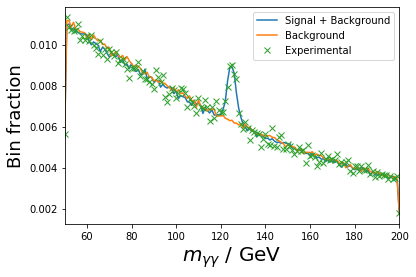

In [4]:
def get_bin_fractions(series):
    series_hist = series.round().value_counts().sort_index()
    return series_hist/series_hist.sum()

h_0_sim_hist = get_bin_fractions(h_0_simulated_data['m_jj'])
h_1_sim_hist = get_bin_fractions(h_1_simulated_data['m_jj'])
ex_hist = get_bin_fractions(experimental_data['m_jj']) 
h_1_sim_hist.plot(label='Signal + Background', xlim=[60, 190])
h_0_sim_hist.plot(label='Background')
plt.plot(ex_hist.index, ex_hist.values, 'x', label='Experimental')
plt.xlabel('$m_{\gamma \gamma}$ / GeV', fontsize=20)
plt.ylabel('Bin fraction', fontsize=18)
plt.legend()

This certainly looks like we have a Higgs boson, but with what statistical significance could we make that statement? In a real experiment we would perform a rigorous statistical test, but for our purposes it is sufficient to use the approximation

$$ z \approx \frac{S}{\sqrt{B}} \, ,$$

where $S$ is the number of signal events and $B$ is the number of background events (in reality we would not have access to these numbers for experimental data, but we have actually simulated our 'experimental' data).

The significance $z$ is related to the $p$-value by

$$ p = \Phi (z) \, ,$$

where $\Phi$ is the cumulative distribution function of the standard Gaussian.

In [5]:
def estimate_significance(data):
    return (data['signal'].sum())/np.sqrt(data['signal'].count())


print('z = {:.2f}'.format(estimate_significance(experimental_data)))

z = 4.38


So we have a result that is slightly below the significance required to claim discovery in particle physics ($z=5$). In order to better isolate our signal, we need to perform cuts on the data, which means placing restrictions on the observables. To inform us about which cuts to make, we can plot the distribution of $E_T$ for the signal events in our simulated data.

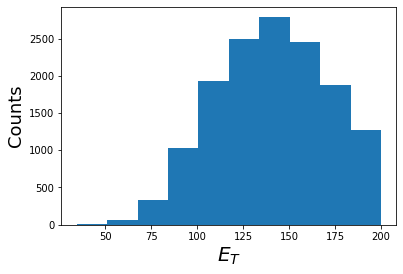

In [6]:
h_1_signal_data = h_1_simulated_data[h_1_simulated_data['signal'] == 1]

h_1_signal_data['E_t'].plot.hist()
plt.xlabel('$E_T$', fontsize=20)
plt.ylabel('Counts', fontsize=18)
plt.show()

So it appears that signal events (according to our simulation) tend to have higher values of $E_T$, so it makes sense to use a cut enforcing this such as

$$ E_T > 100 \text{ GeV} \, .$$

In [15]:
cut_data = experimental_data[experimental_data['E_t'] > 100]
estimate_significance(cut_data)

5.515967980814459

Thus we now have the significance level required to claim the discovery of a Higgs boson.


## 2 Measurement of Higgs boson properties